In [ ]:
# pip install tensorflow matplotlib scikit-learn keras-tuner keras

In [5]:
import gc

import tensorflow as tf
%matplotlib inline

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.callbacks import EarlyStopping # Callback for early stopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split
from kerastuner.tuners import Hyperband
from tensorflow.keras.datasets import fashion_mnist

import matplotlib.pyplot as plt
import numpy as np

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.16.1


In [6]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# Defining the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


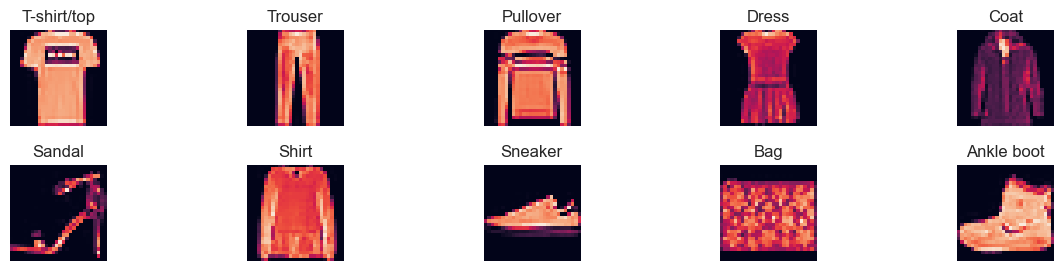

Number of unique classes in the CIFAR-10 dataset:  10


In [8]:
unique_classes = np.unique(y_train)
unique_classes_len = len(unique_classes)

unique_classes, first_occurrence_indices = np.unique(y_train, return_index=True)

# Normalize pixel values to be between 0 and 1 for display
x_train_normalized = x_train / 255.0

# Display one image from each class with class names in a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(15, 3))  # Adjust the figsize as needed
for i, idx in enumerate(first_occurrence_indices):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(x_train_normalized[idx])
    axs[row, col].axis('off')
    axs[row, col].set_title(class_names[unique_classes[i]])

plt.subplots_adjust(hspace=0.4, wspace=0.1)  # Increase hspace and decrease wspace as needed
plt.show()

print("Number of unique classes in the MNIST FASHION dataset: ", unique_classes_len)

In [9]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Flatten the images into 1D vectors (32x32x3 images into 3072-dimensional vectors)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Convert class vectors to binary class matrices (for use with categorical_crossentropy)
y_train = to_categorical(y_train, unique_classes_len)
y_test = to_categorical(y_test, unique_classes_len)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

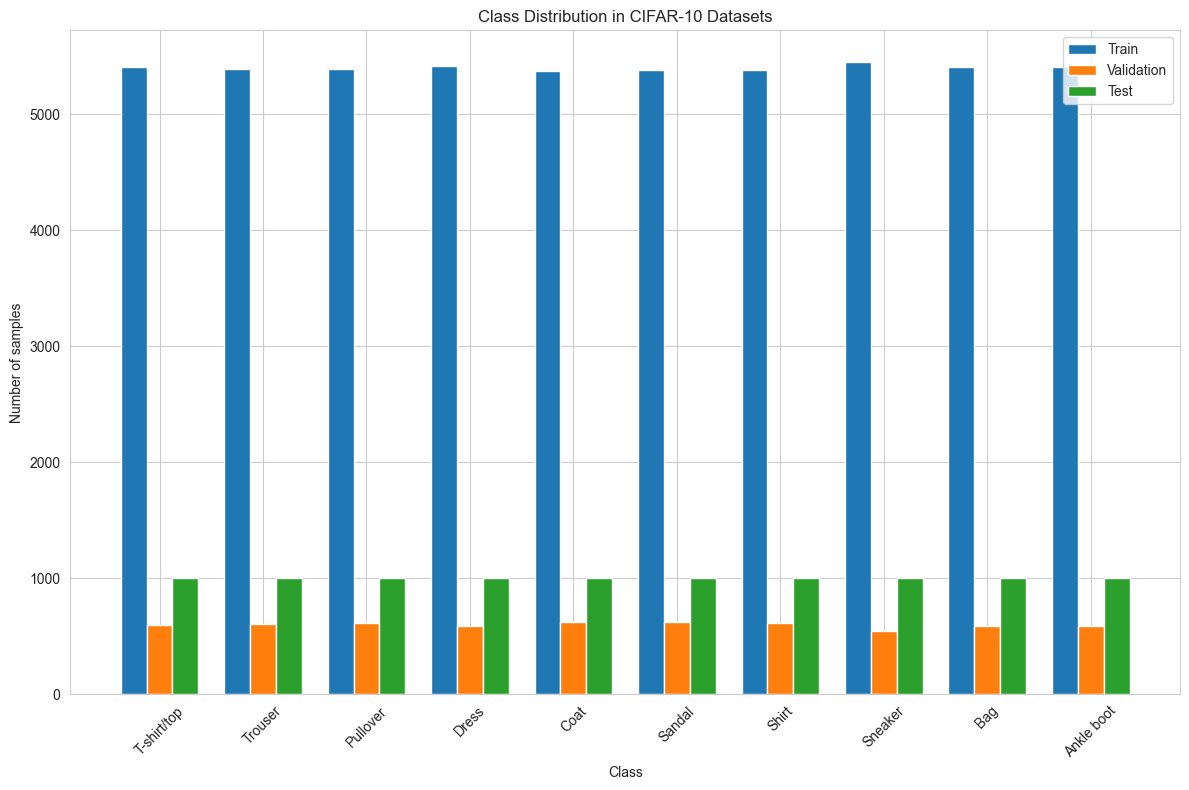

In [10]:
# Function to calculate class distribution
def calculate_class_distribution(y_dataset):
    # Since the labels are one-hot encoded, summing them will give us the count per class
    class_distribution = np.sum(y_dataset, axis=0)
    return class_distribution

# Calculate class distributions
train_class_distribution = calculate_class_distribution(y_train)
val_class_distribution = calculate_class_distribution(y_val)
test_class_distribution = calculate_class_distribution(y_test)

# Plotting the distributions
def plot_class_distribution(train_dist, val_dist, test_dist, unique_classes_len):
    fig, ax = plt.subplots(figsize=(12, 8))
    index = np.arange(unique_classes_len)
    bar_width = 0.25

    # Plot each distribution with an offset for the bar position
    plt.bar(index, train_dist, bar_width, label='Train')
    plt.bar(index + bar_width, val_dist, bar_width, label='Validation')
    plt.bar(index + 2 * bar_width, test_dist, bar_width, label='Test')

    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class Distribution in CIFAR-10 Datasets')
    plt.xticks(index + bar_width, class_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_class_distribution(train_class_distribution, val_class_distribution, test_class_distribution, unique_classes_len)


In [19]:
def build_model(
    optimizer,
    neurons_per_layer,
    dropout_rates=None,
    batch_norm=False
):

    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_seed(1996) # Define the seed for Tensorflow to have reproducible experiments.

    # Define the input layer.
    input = Input(
        shape=(784,),
        name='Input'
    )

    x = input
    # Define the remaining hidden layers.
    for i, neurons in enumerate(neurons_per_layer):
        x = Dense(units=neurons, kernel_initializer='glorot_uniform', activation='relu', name=f'Hidden-{i+1}')(x)
        if batch_norm & i > 0:
            x = BatchNormalization()(x)
        if dropout_rates is not None:
            x = Dropout(dropout_rates[i], name=f'Dropout-{i+1}')(x)  # Apply specified dropout rate for the layer

    # Define the output layer.
    output = Dense(
        units=10,
        kernel_initializer='glorot_uniform',
        activation='softmax',
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [20]:
def build_model_with_hp(hp):
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd'])

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=hp.Float('adam_learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        )
    elif optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=hp.Float('sgd_learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        )


    # Define the number of layers based on a hyperparameter
    hidden_layers = hp.Int('hidden_layers', min_value=0, max_value=3, step=1)

    dropout_rates = [hp.Float(f'dropout_rate_layer{i}', min_value=0.0, max_value=0.5, step=0.1) for i in range(1, hidden_layers + 1)]

    batch_norm = hp.Boolean('batch_norm')

    neurons_per_layer = []
    for i in range(1, hidden_layers+1):
        # For each layer, define a hyperparameter for the number of neurons
        neurons = hp.Int(f'neurons_layer{i}', min_value=64, max_value=512, step=64)
        neurons_per_layer.append(neurons)

     # Build and return the model
    return build_model(
        optimizer=optimizer,
        neurons_per_layer=neurons_per_layer,
        dropout_rates=dropout_rates,
        batch_norm=batch_norm
    )

In [21]:
def search_best_batch_size(x_train, y_train, x_val, y_val, batch_sizes=[64, 128, 256, 512]):
    tuners = {}  # Store tuners by batch size
    best_batch_size = None
    best_val_accuracy = 0

    for batch_size in batch_sizes:
        print(f"Testing batch size: {batch_size}")

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        tuner = Hyperband(
            build_model_with_hp,
            objective='val_accuracy',
            max_epochs=20,
            directory='my_dir_mnist',
            project_name=f'1batch_size_{batch_size}',
        )

        tuner.search(x_train, y_train, validation_data=(x_val, y_val), callbacks=[early_stopping], batch_size=batch_size)

        best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
        val_accuracy = best_trial.score

        print(f"Batch size {batch_size} - Best Validation Accuracy: {val_accuracy}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_batch_size = batch_size

        # Store the tuner for later retrieval
        tuners[batch_size] = tuner

    print(f"Best batch size: {best_batch_size} with Validation Accuracy: {best_val_accuracy}")

    # Return the best batch size and the tuners dictionary
    return best_batch_size, tuners

In [22]:
bbs, tuners = search_best_batch_size(x_train, y_train, x_val, y_val)

Trial 30 Complete [00h 00m 11s]
val_accuracy: 0.8920000195503235

Best val_accuracy So Far: 0.8945000171661377
Total elapsed time: 00h 02m 42s
Batch size 512 - Best Validation Accuracy: 0.8945000171661377
Best batch size: 256 with Validation Accuracy: 0.8981666564941406


In [23]:
tuner_best_model = tuners[bbs].get_best_models(num_models=1)[0]
tuner_best_model.evaluate(x_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.8870 - loss: 0.3269


[0.3232276737689972, 0.8865000009536743]

In [25]:
import json
best_hps = tuners[bbs].get_best_hyperparameters(num_trials=1)[0]
json_str = json.dumps(best_hps.values, indent=4)

# Print the pretty-printed JSON string
print(json_str)

{
    "optimizer": "adam",
    "adam_learning_rate": 0.00012192715180060102,
    "hidden_layers": 3,
    "batch_norm": true,
    "dropout_rate_layer1": 0.1,
    "dropout_rate_layer2": 0.0,
    "neurons_layer1": 448,
    "neurons_layer2": 512,
    "sgd_learning_rate": 0.00015828913115208012,
    "dropout_rate_layer3": 0.30000000000000004,
    "neurons_layer3": 448,
    "tuner/epochs": 20,
    "tuner/initial_epoch": 7,
    "tuner/bracket": 2,
    "tuner/round": 2,
    "tuner/trial_id": "0012"
}


In [26]:
from tensorflow.keras.optimizers import Adam

built_model = build_model(Adam(0.00012192715180060102), [448, 512, 448], [0.1,0,0.3], True)

hs = built_model.fit(
        x=x_train,
        y=y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=20,
        verbose=0,
        batch_size=bbs
    )
print('Finished training.')
print('------------------')
built_model.summary() # Print a description of the model.

Finished training.
------------------


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden-1 (Dense)                │ (None, 448)            │       351,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout-1 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden-2 (Dense)                │ (None, 512)            │       229,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout-2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden-3 (Dense)                │ (None, 448)            │       229,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout-3 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │         4,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,451,744 (9.35 MB)

 Trainable params: 816,906 (3.12 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 1,633,814 (6.23 MB)

In [27]:
hs_eval = built_model.evaluate(x_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.8843 - loss: 0.3478


In [30]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()


Train Loss     : 0.15126
Validation Loss: 0.32542
Test Loss      : 0.33848
---
Train Accuracy     : 0.94455
Validation Accuracy: 0.89370
Test Accuracy      : 0.88770



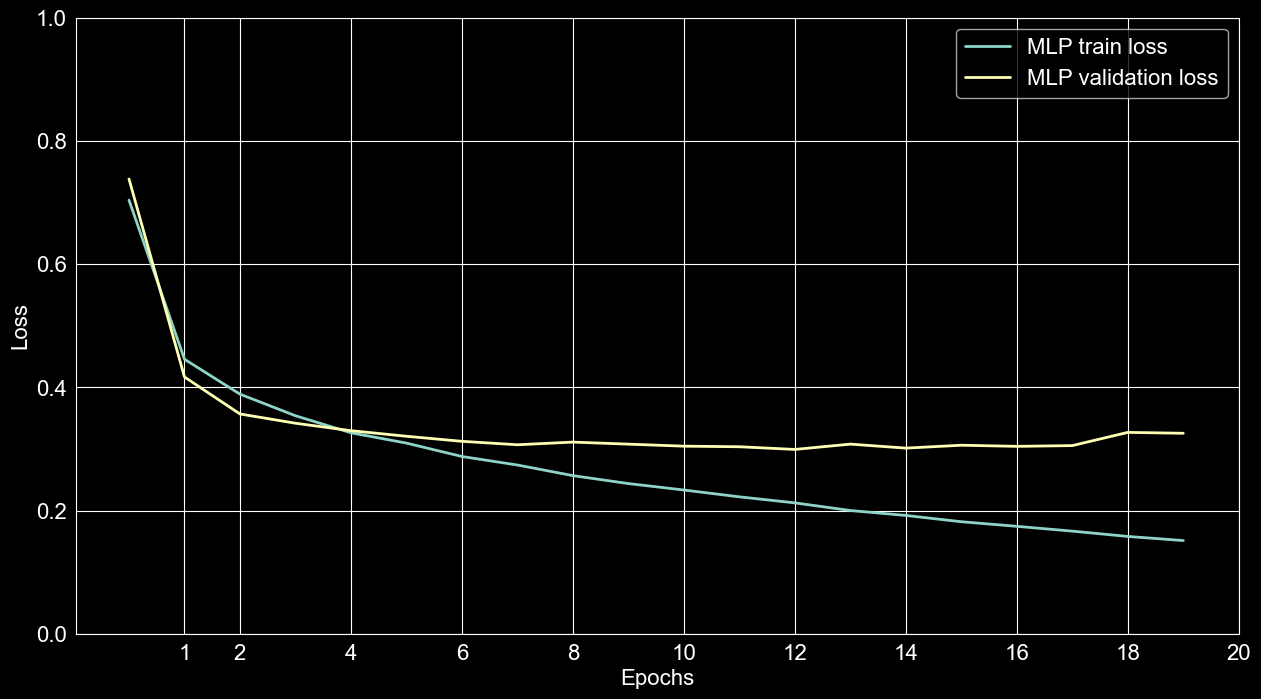

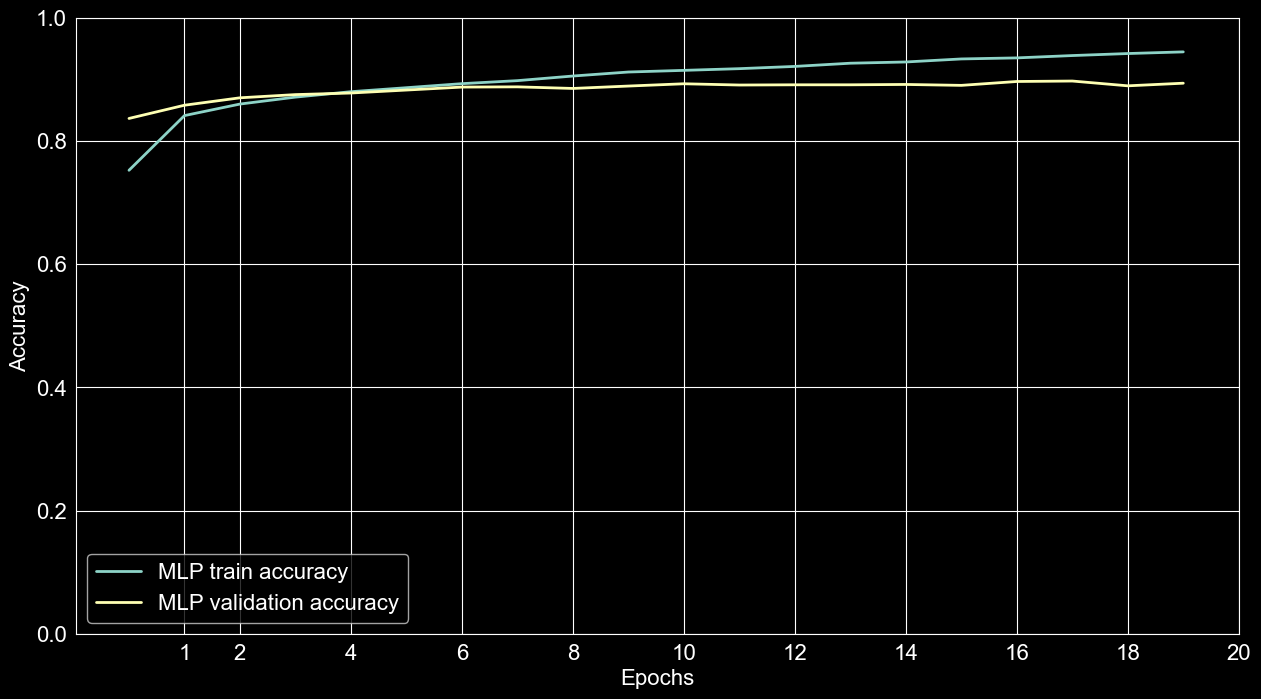

In [31]:
print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(hs_eval[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(hs_eval[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP': hs}, epochs=20, metric='loss')
plot_history(hs={'MLP': hs}, epochs=20, metric='accuracy')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


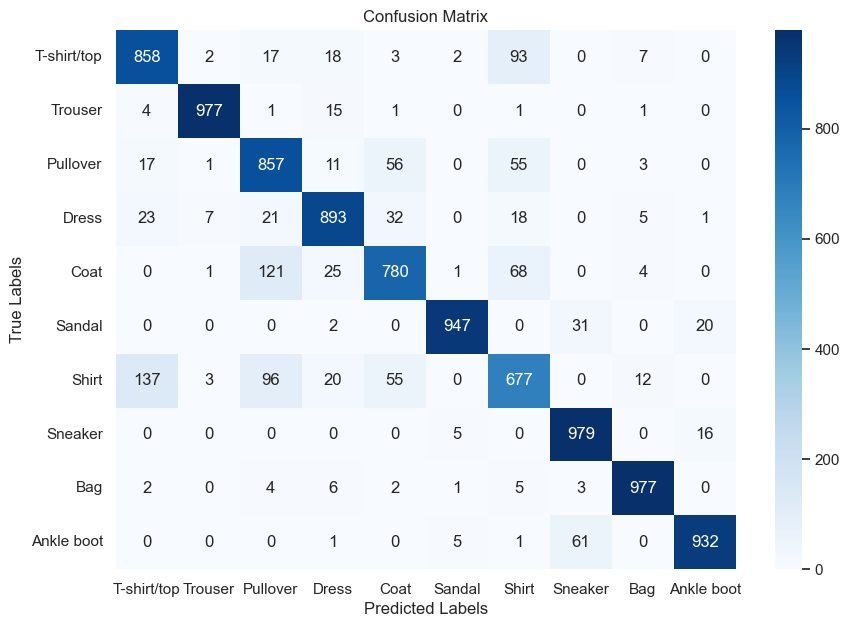

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `predictions` are the raw outputs from your model, e.g., softmax probabilities
# Convert predictions and true labels from one-hot encoded to class indices
predictions = np.argmax(built_model.predict(x_test), axis=-1)
y_test_indices = np.argmax(y_test, axis=-1)  # Only if y_test is one-hot encoded

sns.set_theme(style="white")
# Calculate the confusion matrix
cm = confusion_matrix(y_test_indices, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [33]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming your model's prediction function returns the class probabilities
predictions_prob = built_model.predict(x_test)  # Get model predictions for the test set

# Convert probabilities to predicted class labels
predictions = np.argmax(predictions_prob, axis=1)

# Assuming y_test is one-hot encoded, convert it to single integer labels
y_true = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true, predictions, target_names=class_names)

print(report)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.86      0.84      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.77      0.86      0.81      1000
       Dress       0.90      0.89      0.90      1000
        Coat       0.84      0.78      0.81      1000
      Sandal       0.99      0.95      0.97      1000
       Shirt       0.74      0.68      0.71      1000
     Sneaker       0.91      0.98      0.94      1000
         Bag       0.97      0.98      0.97      1000
  Ankle boot       0.96      0.93      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [66]:
misclassified_indices = np.where(predictions_prob != y_test)[0]
y_test_class_indices = np.argmax(y_test, axis=1)

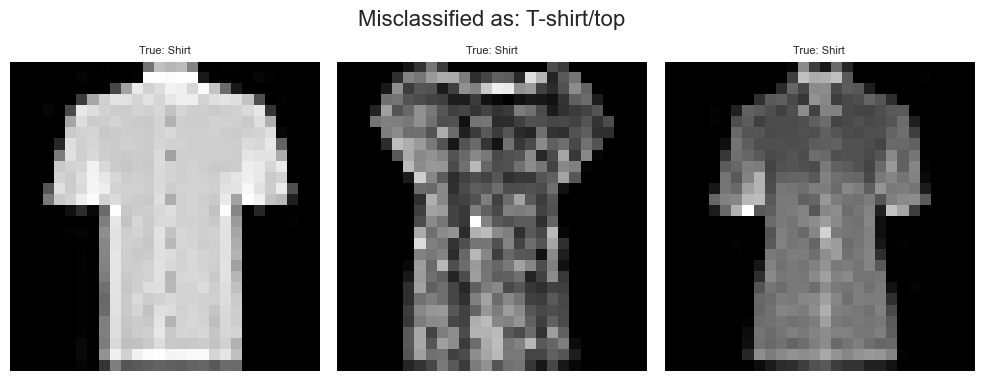

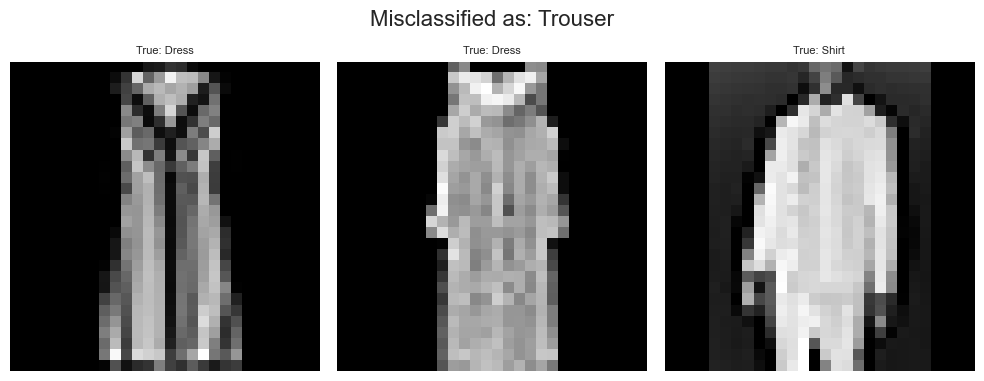

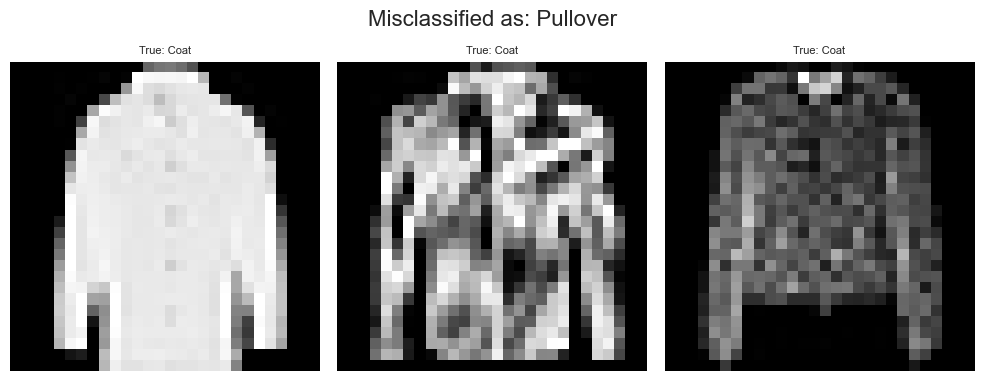

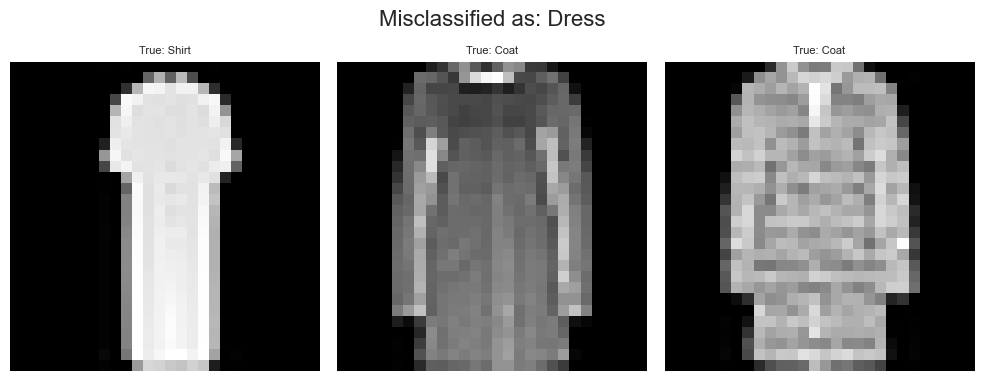

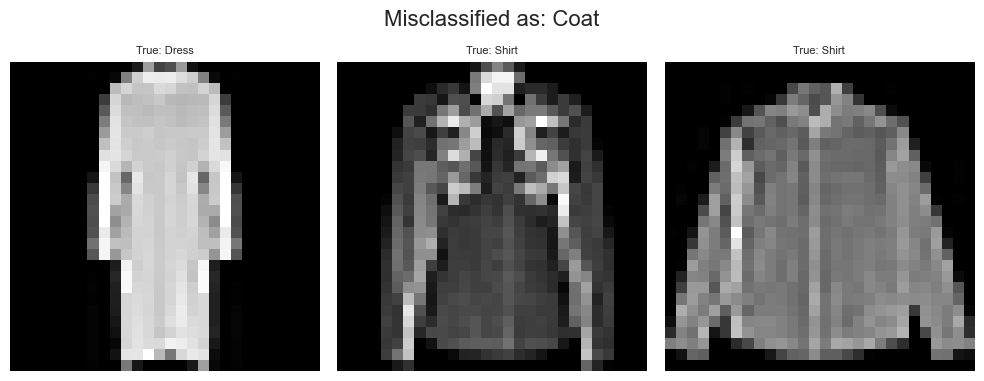

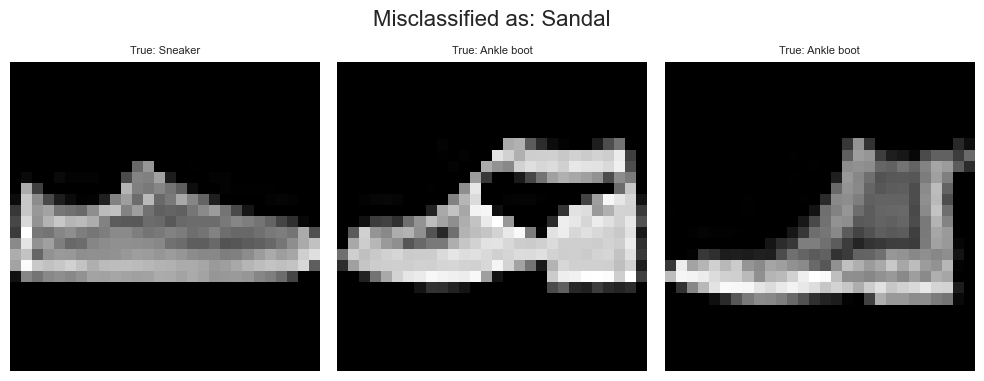

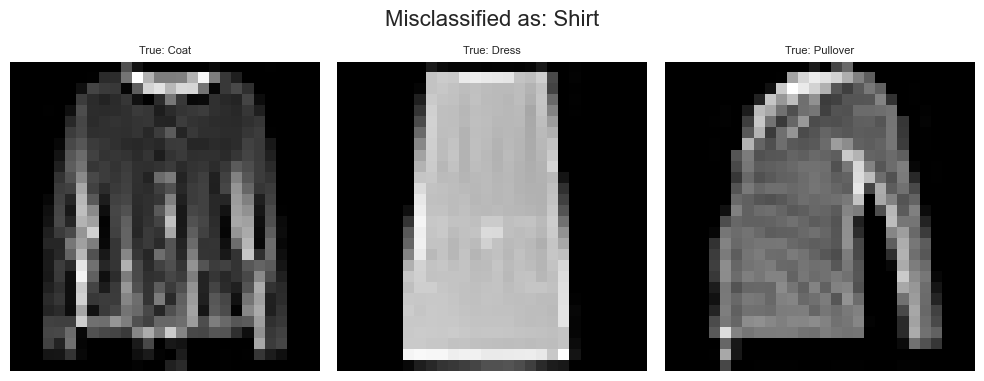

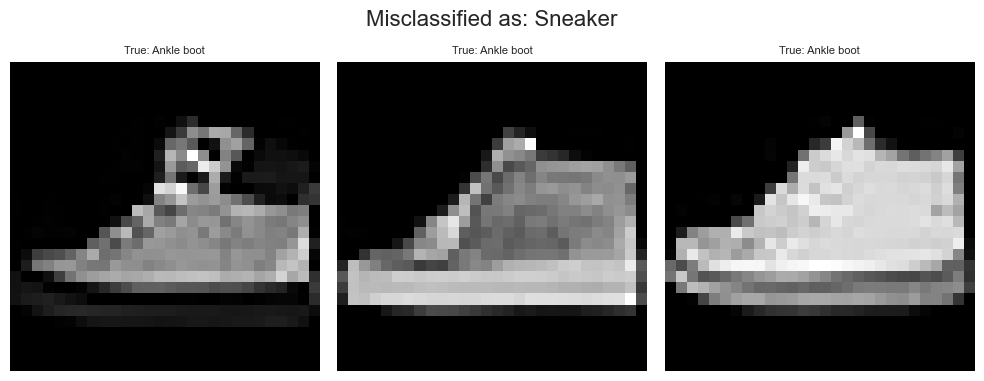

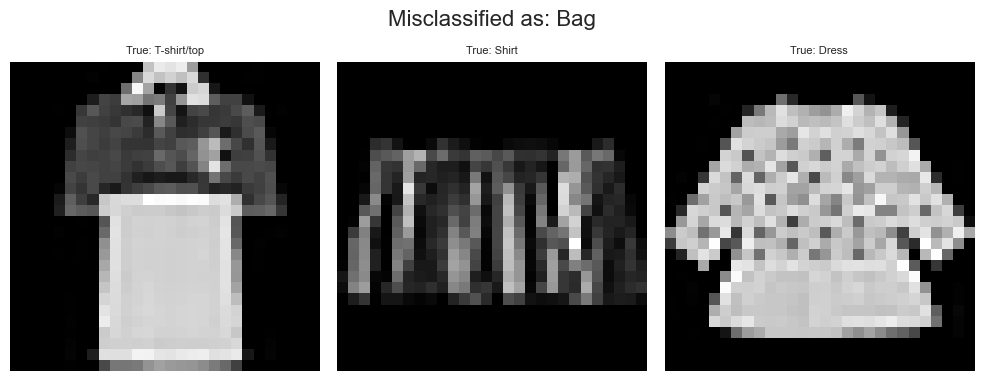

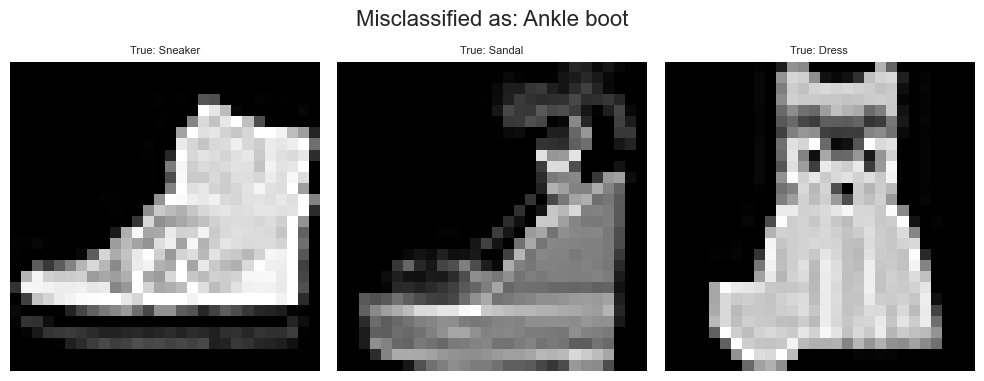

In [67]:
def plot_images(images, titles, pred_class_name, nrows=1, ncols=3):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4))
    fig.suptitle(f"Misclassified as: {pred_class_name}", fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.set_title(titles[i], fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

for pred_class_idx, pred_class_name in enumerate(class_names):
    # Find indices where the prediction was pred_class_idx but the true class was different
    misclassified_indices = np.where((predictions == pred_class_idx) &
                                     (y_test_class_indices != pred_class_idx))[0]

    # Select a subset of misclassified images for this predicted class
    subset_indices = misclassified_indices[:3]  # Adjust as needed
    if len(subset_indices) > 0:
        # Ensure images are reshaped from (784,) to (28, 28) for plotting
        images = [x_test[i].reshape(28, 28) for i in subset_indices]
        titles = [f"True: {class_names[y_test_class_indices[i]]}" for i in subset_indices]

        plot_images(images, titles, pred_class_name)